# Daily run script to generate playlists followers reports

### 0. Import libraries

In [138]:
import sys
sys.path.append("../../")

from src.common.config import setup_logger
from src.common.spotify_auth import execute_spotify_auth
from src.common.telegram_alerts import init_telegram_bot, send_daily_follower_report, send_telegram_message

from spotipy import Spotify
import pandas as pd
import requests
from datetime import date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4

from io import BytesIO
from PIL import Image
import logging
import asyncio
import os
import subprocess
from dotenv import load_dotenv

### 1. Custom functions

In [139]:
def get_playlists_data(sp: Spotify, 
                       cover_images_folder: str,
                       logger: logging.Logger) -> pd.DataFrame:
    playlists = sp.current_user_playlists()
    data = {}
    
    for playlist in playlists['items']:
        name = playlist['name']
        name = "_".join(name.split())
        playlist_id = playlist['id']
        
        # looking for the playlist based on id to get details
        logger.info(f"Extracting {name} info.")
        playlist_details = sp.playlist(playlist_id)
        followers = playlist_details['followers']['total']
        data.update({name : int(followers)})        
        
        logger.info(f"Extracting {name} cover image.")
        # getting and saving playlist cover to a file
        cover_url = playlist_details['images'][0]['url']
        response = requests.get(cover_url)
        response.raise_for_status()
        cover_image = Image.open(BytesIO(response.content))
        cover_image.save(f"{cover_images_folder}/{name}.png")
      
    data_df = pd.DataFrame(data = [data])
    data_df.index = [pd.to_datetime(date.today())]

    return data_df

In [140]:
def update_the_historical_data(data_df: pd.DataFrame, csv_url: str) -> pd.DataFrame:
    
    hist_df = pd.read_csv(csv_url, index_col = 0)
    
    hist_df.index = pd.to_datetime(hist_df.index)
    hist_df = hist_df.astype(int)
    
    try:
        updated_df = pd.concat([hist_df, data_df], verify_integrity=True)
        
        updated_df.to_csv(csv_url)
    
    except ValueError:
        common_indexes = hist_df.index.intersection(data_df.index)
        hist_df = hist_df.drop(index=common_indexes)
        updated_df = pd.concat([hist_df, data_df], verify_integrity=True)
        updated_df.to_csv(csv_url)

    
    return updated_df

In [141]:
def create_followers_chart(followers_df: pd.DataFrame, 
                           logger: logging.Logger, 
                           charts_path: str,
                           chart_name_suffix: str,
                           days_traceback: int = 365):
    
    sns.set_style("white", {"grid.color": "#2A2A2A"})

    fig, ax = plt.subplots(figsize=(7, 2))

    last_year_days_df = followers_df[followers_df.index > pd.Timestamp(date.today()) - timedelta(days=days_traceback)]
    sns.lineplot(data=last_year_days_df, ax=ax, color='#45ad61', linewidth=4)

    ax.set_ylabel("", fontsize=5, color='white')
    ax.tick_params(axis='x', labelbottom=False)
    ax.tick_params(axis='y', labelleft=False)
    ax.legend().remove()

    ax.grid(color='#808080', axis='y', linestyle='-', linewidth=0.5)

    sns.despine()

    plt.tight_layout()
    name = "_".join(last_year_days_df.name.split())
    
    logger.info(f'Saving {name} follower chart to file.')
    plt.savefig(charts_path + f"/{name}" + chart_name_suffix)

In [142]:
def generate_follower_report(name : str,
                             charts_url: str,
                             chart_name_suffix: str,
                             covers_url: str,
                             followers_df: pd.DataFrame,
                             logger: logging.Logger,
                             chart_width: int = 140, 
                             chart_height: int = 40,
                             cover_size: int = 30,
                             margin: int = 20,
                             horizontal_margin: int = 60,
                             title_margin: int = 5,
                             outline_margin: int = 3,
                             main_font_size: int = 10,
                             secondary_font_size = 9,
                             columns: int = 3, 
                             page_height: float = A4[1]) -> canvas.Canvas:
    
    x, y = margin, page_height - chart_height
    c = canvas.Canvas(name, pagesize=A4)
    
    # Report title
    title = date.today().strftime("%d.%m.%Y") + " PulseBeats playlists followers report"
    c.setFont("Helvetica-Bold", main_font_size * 2)
    c.drawString(x, 
                 y, 
                 title)
    
    y -= chart_height

    for i, playlist_name in enumerate(followers_df.columns):
        chart_path = f'{charts_url}/{playlist_name}' + chart_name_suffix
        cover_path = f'{covers_url}/{playlist_name}.png'
        current_followers = followers_df[playlist_name].iloc[-1]
        a_week_ago_delta = current_followers - followers_df[playlist_name].iloc[-8]
        a_month_ago_delta = current_followers - followers_df[playlist_name].iloc[-31]

        try:
            # playlist cover
            c.drawImage(cover_path, 
                        x, 
                        y - cover_size, 
                        width=cover_size, 
                        height=cover_size)

            # playlist title
            display_name = " ".join((playlist_name.split('.')[0]).split("_"))
            if len(display_name) > 20:
                display_name = display_name[:20] + "..."
                
            c.setFont("Helvetica-Bold", main_font_size)
            c.drawString(x + cover_size + title_margin, 
                         y - main_font_size + 2, 
                         display_name)
            
            # current followers count
            c.setFont("Helvetica-Bold", main_font_size)
            c.drawString(x + cover_size + title_margin, 
                         y - main_font_size * 2 - outline_margin, 
                         str(current_followers))
            
            # week's growth
            c.setFont("Helvetica-Bold", secondary_font_size)
            c.drawString(x, 
                         y - cover_size - chart_height - secondary_font_size, 
                         "In the last week: ")
            if a_week_ago_delta > 0:
                c.setFillColorRGB(0.27, 0.68, 0.38)
            else:
                c.setFillColorRGB(0.68, 0.27, 0.27)
            display_week_value = f'+{a_week_ago_delta}' if a_week_ago_delta > 0 else f'{a_week_ago_delta}'
            c.drawString(x + 80, 
                        y - cover_size - chart_height - secondary_font_size, 
                        display_week_value)
            c.setFillColorRGB(0, 0, 0)
            
            # month's growth
            c.setFont("Helvetica-Bold", secondary_font_size)
            c.drawString(x, 
                         y - cover_size - chart_height - secondary_font_size * 2 - outline_margin, 
                         "In the last month: ")
            if a_month_ago_delta > 0:
                c.setFillColorRGB(0.27, 0.68, 0.38)
            else:
                c.setFillColorRGB(0.68, 0.27, 0.27)
            display_month_value = f'+{a_month_ago_delta}' if a_month_ago_delta > 0 else f'{a_month_ago_delta}'
            c.drawString(x + 80, 
                        y - cover_size - chart_height - secondary_font_size * 2 - outline_margin, 
                        display_month_value)
            c.setFillColorRGB(0, 0, 0)

            # line plot image
            c.drawImage(chart_path, 
                        x - outline_margin, 
                        y - cover_size - chart_height, 
                        width=chart_width, 
                        height=chart_height)

            # x pos update
            x += chart_width + horizontal_margin
            if (i + 1) % columns == 0:
                x = margin  # reset x
                y -= 130  # new line

                # new page if theres no space
                if y < margin + cover_size:
                    c.showPage()
                    y = page_height - cover_size - chart_height - 2 * margin
                    
        except Exception as e:
            logger.error(f"Error while generating the followers report: {e}")

    return c

In [143]:
def replace_the_report(report: canvas.Canvas, 
                       report_path: str,
                       logger: logging.Logger):
    
    reports = os.listdir(report_path)
    
    if len(reports) > 0:
        for file in reports:
            logger.info(f"Removing {file} from local data folder.")
            os.remove(os.path.join(report_path, file))
        
    logger.info("Saving new report locally.")
    report.save()

In [144]:
def push_report_to_mega(report_name: str,
                        logger: logging.Logger):
    
    try:
        #saving to MEGA
        logger.info("Authorizing MEGA.")
        load_dotenv()
        mega_login = os.getenv("MEGA_LOGIN")
        mega_password = os.getenv("MEGA_PASSWORD")
        
        subprocess.run(f'mega-login "{mega_login}" "{mega_password}"', shell=True, check=True)
        
        logger.info("Pushing new report to MEGA.")
        subprocess.run(f"mega-put {report_name} /playlists_reports", shell=True, check=True)
        
        logger.info("Logging out of MEGA.")
        subprocess.run(f'mega-logout', shell=True, check=True)
        
    except subprocess.CalledProcessError as e:
        logger.error(f"Error authorizing or saving report to MEGA: {e}")

In [145]:
async def send_telegram_notif(bot, chat_id, report_name, logger ):
    await send_daily_follower_report(bot, 
                               chat_id, 
                               report_name, 
                               logger)

### 2. Envinroment variables

In [ ]:
date_today = date.today().strftime("%d_%m_%Y")

is_friday = date.isoweekday(date.today()) == 5

data_folder_path = "src/"

csv_url = data_folder_path + "data/follower_count.csv"
report_path = data_folder_path + "data/reports"
report_name = report_path + f"/follower_report_{date_today}.pdf"
charts_url = data_folder_path + "data/assets/charts"
chart_name_suffix = "_last_year_chart.png"
covers_url = data_folder_path + "data/assets/covers"

### 3. Run the code

In [147]:
logger = setup_logger("followers_reporting.py")
logger.info('Starting job initialization.')

2025-06-21 13:30:23 | INFO | followers_reporting.py | Starting job initialization.



2025-06-21 13:30:23 | INFO | followers_reporting.py | Authorizing spotify access.

2025-06-21 13:30:24 | ERROR | followers_reporting.py | NO REFRESH TOKEN RETURNED

2025-06-21 13:30:24 | INFO | followers_reporting.py | Authorizing and initializing telegram bot.

2025-06-21 13:30:24 | INFO | followers_reporting.py | Getting followers data from Spotify.

2025-06-21 13:30:24 | INFO | followers_reporting.py | Extracting DAILY_TOP_50 info.

2025-06-21 13:30:24 | INFO | followers_reporting.py | Extracting DAILY_TOP_50 cover image.

2025-06-21 13:30:25 | INFO | followers_reporting.py | Extracting DAILY_TOP_100 info.

2025-06-21 13:30:25 | INFO | followers_reporting.py | Extracting DAILY_TOP_100 cover image.

2025-06-21 13:30:25 | INFO | followers_reporting.py | Extracting DAILY_TOP_200 info.

2025-06-21 13:30:26 | INFO | followers_reporting.py | Extracting DAILY_TOP_200 cover image.

2025-06-21 13:30:26 | INFO | followers_reporting.py | Extracting Techno_French_2025 info.

2025-06-21 13:30:26

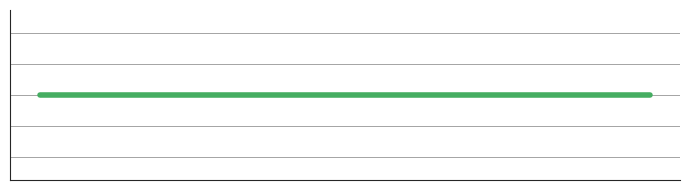

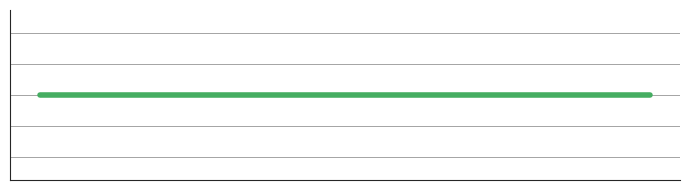

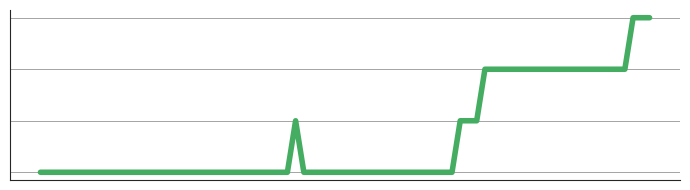

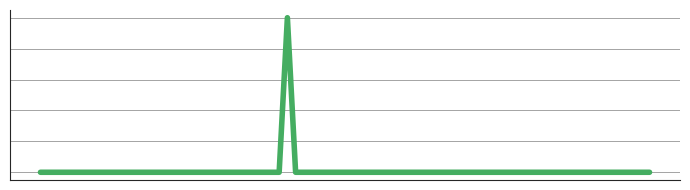

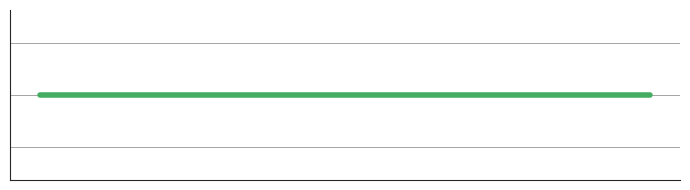

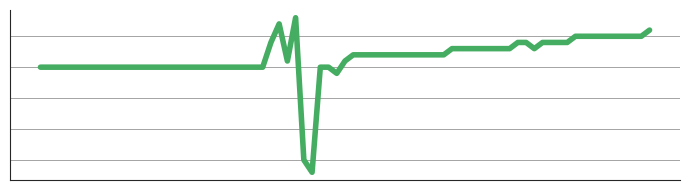

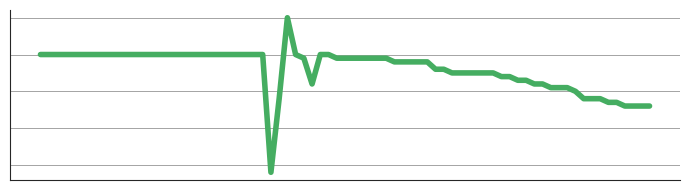

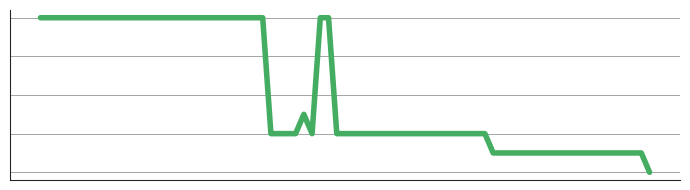

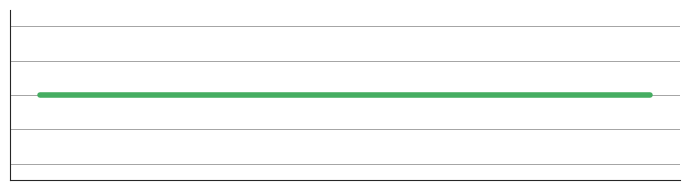

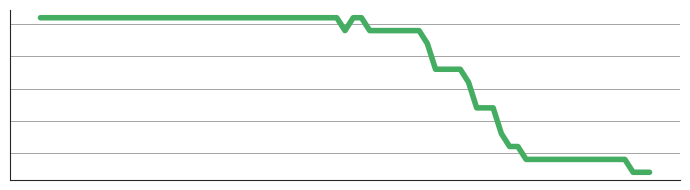

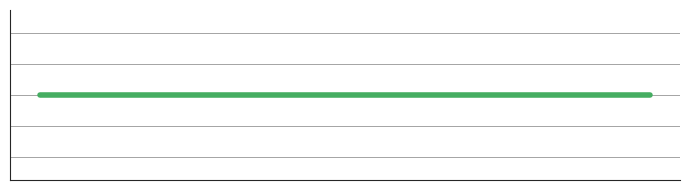

In [ ]:
try:
    logger.info('Authorizing spotify access.')
    sp = execute_spotify_auth(logger)
    
    logger.info('Authorizing and initializing telegram bot.')
    bot, chat_id = init_telegram_bot()
    
    logger.info('Getting followers data from Spotify.')
    df = get_playlists_data(sp, covers_url, logger)
    
    logger.info('Updating local followers data.')
    updated_df = update_the_historical_data(df, csv_url)
    
    logger.info('Creating follower charts.')
    for col in updated_df.columns:
        create_followers_chart(updated_df[col], logger, charts_url, chart_name_suffix)
    
    logger.info('Generating follower report.')
    report = generate_follower_report(name=report_name, 
                                      charts_url=charts_url, 
                                      chart_name_suffix=chart_name_suffix,
                                      covers_url=covers_url,
                                      followers_df=updated_df,
                                      logger=logger)
    
    logger.info('Replacing the report locally.')
    replace_the_report(report, report_path, logger)
    
    if is_friday:
        logger.info(f'is_friday = {is_friday}, saving the report on MEGA.')
        push_report_to_mega(report_name, logger)
        asyncio.run(send_telegram_message(bot, chat_id, "Report pushed to MEGA.", logger))   
    else:
        logger.info('Sending the report to Telegram.')
        asyncio.run(send_telegram_notif(bot, chat_id, report_name, logger))
        
    logger.info('Job finished.')

except Exception as e:
    logger.error(f'Playlist followers reports pipeline fail: {e}')